# GenePy - a tutorial

In [1]:
import numpy as np
from genepy import genepy, examples
import matplotlib.pyplot as plt

##### Plotting configurations

In [2]:
plt.rcParams['font.size']        = 12
plt.rcParams['text.usetex']      = True
plt.rcParams['xtick.direction']  = 'in'
plt.rcParams['ytick.direction']  = 'in'

In [3]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

## Choose a test function

First choose a test function (your actual objective function to be minimized replaces this). Here we choose the Alpine function $$f(x,y) = |x\sin{x} + 0.1x| + |y\sin{y} + 0.1y|.$$

In [4]:
test_fn = examples.alpine

Let's have a quick look at the optimization surface

In [5]:
x  = np.linspace(-10, 10, 200)
y  = np.linspace(-10, 10, 200)
xg, yg = np.meshgrid(x,y)
xy = np.column_stack([xg.ravel(), yg.ravel()])
z  = test_fn(xy).reshape(xg.shape)

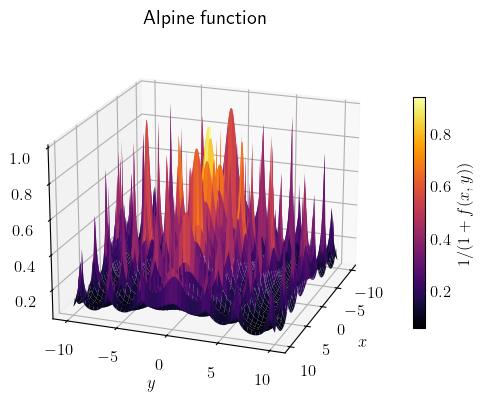

In [6]:
fig = plt.figure(figsize = (6,6))
ax  = fig.add_subplot(111, projection = '3d')
surf = ax.plot_surface(xg, yg, 1/(1+z), cmap = 'inferno')
ax.view_init(elev = 20, azim = 20)
cbar = fig.colorbar(surf, ax = ax, shrink = 0.5)
cbar.ax.tick_params(which = 'both', length=0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
cbar.set_label('$1/(1 + f(x,y))$')
plt.title("Alpine function", pad = 0)
plt.show()

## Preparing GA

In GA we maximize a fitness function. If the objective is minimization, simply turn it around by the reciprocal.

In [7]:
def fitness(x):
    # fitness is always maximized
    return 1/(1 + test_fn(x))

Let's configure some initial GA hyperparameters

In [8]:
decimals   = 4
n_var      = 2
var_ranges = np.array([[-10,]*n_var,[10,]*n_var])
n_bits_segment    = len(format(int(max(var_ranges[1] - var_ranges[0])*10**decimals), 'b'))
n_bits_chromosome = n_bits_segment * n_var
offset    = -var_ranges[0]

In [9]:
print(f"Size of each chromosome is {n_bits_chromosome} bits and each segment is {n_bits_segment}.")

Size of each chromosome is 36 bits and each segment is 18.


Now create an instance of `PopGenetics`.

In [10]:
PopGen = genepy.PopGenetics(
    fitness_func = fitness,
    n_var = n_var,
    decimal_acc = decimals,
    n_bits_chromosome = n_bits_chromosome,
)

### Initializing a population

In [11]:
init_popsize = 500
pop_bin = PopGen.initialize_population(
    popsize = init_popsize, 
    var_ranges = var_ranges, 
    return_genotype = True,
    offset = offset,
)
pop_bin.shape

(500, 36)

Looking at the population in the phenotype representation

In [12]:
pop_dec = genepy.pop_bin2dec(
    pop_bin, 
    n_bits_segment, 
    decimal_acc = decimals, 
    offset = offset,
)
pop_dec.shape

(500, 2)

In [13]:
pop_fitness = fitness(pop_dec)
pop_fitness.shape

(500,)

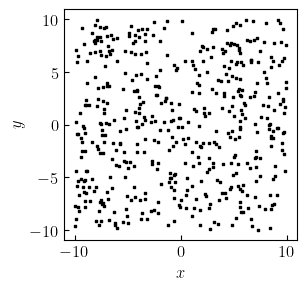

In [14]:
plt.figure(figsize = (3,3))
plt.scatter(
    pop_dec[:,0], 
    pop_dec[:,1], 
    color = 'k',
    marker = 's',
    s = 4,
    # c = pop_fitness,
    # cmap = 'inferno',
)
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

### Running evolution

Setting some evolution hyperparameters

In [15]:
n_gen    = 20 
n_pairs  = 800
n_elites = 3
switch_selection = 5
prob_mut = 0.02
pruning_cutoff = 800

And evolve!

In [16]:
evol_rec = PopGen.evolve(
    pop_bin, 
    n_gen    = n_gen, 
    n_pairs  = n_pairs,
    elitist  = True,
    n_elites = n_elites,
    liberal  = False,
    n_runts  = 0,
    switch_selection = switch_selection,
    prob_mut = prob_mut, 
    prune    = True,
    pruning_cutoff = pruning_cutoff,
    verbose  = True,
    n_workers = 1,
)

[genepy] Evolution in progress: 100%|██████████| 20/20 [00:03<00:00,  5.88gen/s]


In [17]:
print(f"Best solution found: {evol_rec['fittest_individual']}\nwith fitness: {evol_rec['best_overall_fitness']}") 

Best solution found: [ 0.     -0.1002]
with fitness: 0.9999967519792644


Let's look at the evolution curves

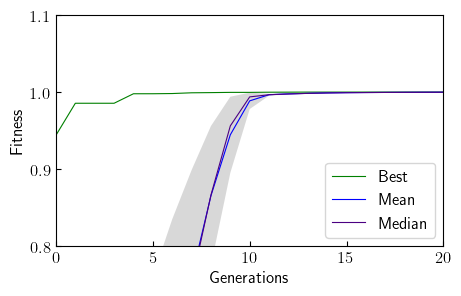

In [18]:
plt.figure(figsize = (5,3))
gens = np.arange(len(evol_rec['best_fitness_per_generation']))
plt.plot(gens, evol_rec['best_fitness_per_generation'], color = 'green', label = 'Best', lw = 0.8)
plt.plot(gens, evol_rec['mean_fitness_per_generation'], color = 'blue', label = 'Mean', lw = 0.8)
plt.plot(gens, evol_rec['median_fitness_per_generation'], color = 'indigo', label = 'Median', lw = 0.8)
plt.fill_between(
    gens,
    evol_rec['mean_fitness_per_generation'] - evol_rec['stdev_fitness_per_generation'], 
    evol_rec['mean_fitness_per_generation'] + evol_rec['stdev_fitness_per_generation'], 
    color = 'grey', 
    alpha = 0.3,
    lw = 0.0,
)
plt.legend()

plt.ylim(0.8, 1.1)
# plt.ylim(0.995, 1.001)
# plt.ylim(0.9995, 1.0001)
# plt.ylim(0.99995, 1.00001)
plt.xlim(gens[0], gens[-1])

# plt.yscale('log')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()

### Continuing evolution

The previous evolution run doesn't seem to have coverged to the global optimal yet. We can continue evolution from the last point simply by supplying a larger number of generations, `n_gen`.

In [19]:
n_gen = 50 
evol_rec = PopGen.evolve(
    pop_bin, 
    n_gen    = n_gen, 
    n_pairs  = n_pairs,
    elitist  = True,
    n_elites = n_elites,
    liberal  = False,
    n_runts  = 0,
    switch_selection = switch_selection,
    prob_mut = prob_mut, 
    prune    = True,
    pruning_cutoff = pruning_cutoff,
    verbose  = True,
    n_workers = 1,
)

[genepy] Evolution in progress: 100%|██████████| 50/50 [00:05<00:00,  5.75gen/s]


In [20]:
print(f"Best solution found: {evol_rec['fittest_individual']}\nwith fitness: {evol_rec['best_overall_fitness']}") 

Best solution found: [0. 0.]
with fitness: 1.0


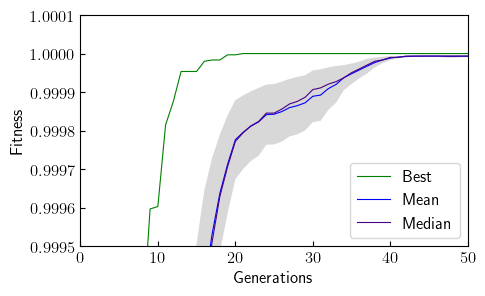

In [21]:
plt.figure(figsize = (5,3))
gens = np.arange(len(evol_rec['best_fitness_per_generation']))
plt.plot(gens, evol_rec['best_fitness_per_generation'], color = 'green', label = 'Best', lw = 0.8)
plt.plot(gens, evol_rec['mean_fitness_per_generation'], color = 'blue', label = 'Mean', lw = 0.8)
plt.plot(gens, evol_rec['median_fitness_per_generation'], color = 'indigo', label = 'Median', lw = 0.8)
plt.fill_between(
    gens,
    evol_rec['mean_fitness_per_generation'] - evol_rec['stdev_fitness_per_generation'], 
    evol_rec['mean_fitness_per_generation'] + evol_rec['stdev_fitness_per_generation'], 
    color = 'grey', 
    alpha = 0.3,
    lw = 0.0,
)
plt.legend()

# plt.ylim(0.8, 1.1)
# plt.ylim(0.995, 1.001)
plt.ylim(0.9995, 1.0001)
# plt.ylim(0.99995, 1.00001)
plt.xlim(gens[0], gens[-1])

# plt.yscale('log')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()